# Play with pipeline

### Import

In [ ]:
import os
PROJECT_PATH= os.getenv("IBENS_PROJECT_PATH") or "../../" # type: ignore
os.chdir(PROJECT_PATH)

import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils

#DataModule
from disdiff_adapters.data_module import *
#Module
from disdiff_adapters.arch.vae import *
from disdiff_adapters.arch.multi_distillme import *
#utils
from disdiff_adapters.utils import *
#loss
from disdiff_adapters.loss import *
#metric
from disdiff_adapters.metric import *
#ext
from chada.backbones.vit.chada_vit import ChAdaViT # type: ignore

from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer

BATCH_SIZE = 32
LATENT_DIM = 64

torch.set_float32_matmul_precision('medium')

/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/op

## Load data 

**Choose the appropriate set :**

### 3DShapes

In [ ]:
#6mn30 from ens cluster
shapes = Shapes3DDataModule(batch_size=BATCH_SIZE)
shapes.prepare_data()
shapes.setup(stage='fit')
shapes_loader = shapes.train_dataloader()
# else :
#     images, labels = load_h5(Shapes3D.Path.H5)
#     images = images[:32]
#     labels = labels[:32]
#     shapes_loader = DataLoader(TensorDataset(torch.tensor(images).permute(0,3,1,2), torch.tensor(labels)), batch_size=8, shuffle=True)

NameError: name 'is_gpu' is not defined

In [ ]:
for batch in shapes_loader :
    images, labels = batch
    print(images.shape)
    break

torch.Size([8, 3, 64, 64])


### BloodMNIST

In [2]:
blood = BloodMNISTDataModule(batch_size=BATCH_SIZE)
blood.prepare_data()
blood.setup("fit")
blood_loader = blood.train_dataloader()

### CelebA

In [2]:
celeba = CelebADataModule(batch_size=BATCH_SIZE)
celeba.prepare_data()
celeba.setup("fit")
celeba_loader = celeba.train_dataloader()

### Choose the correct loader

In [9]:
loader = shapes_loader
stop_at = 0

for i,batch in enumerate(loader) :
    images, labels = batch
    in_channels = images.shape[1]
    img_size = images.shape[2]
    if i == stop_at : break
    
print(f"Data selected with in_channels={in_channels} and img_size={img_size}")
toy_loader = DataLoader(TensorDataset(torch.cat(2*[images]), torch.cat(2*[labels])), batch_size=2*32)

NameError: name 'shapes_loader' is not defined

## VAE

### Variational Encoder

Let's display the PCA-latent space with VAE encoder

In [8]:
encoder = Encoder(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)

encoder.eval()
mus = []
logvars = []
labels = []

for i,batch in enumerate(loader) :
    image, label = batch

    mu, logvar = encoder(image)

    mus.append(mu)
    logvars.append(logvar)
    labels.append(label)
    if (stop_at is not None) and (stop_at == i) : break

try :
    mus = torch.cat(mus)
    logvars = torch.cat(logvars)
    labels = torch.cat(labels)
except TypeError as e : print("!!You have already run this cell.!!")
print(f"labels shape = {labels.shape}")

labels shape = torch.Size([32, 40])


Make sure that labels shape is at [Batch size, 1]. Preprocess here if needed :

In [13]:
labels[:, 0].unsqueeze(1).shape

torch.Size([32, 1])

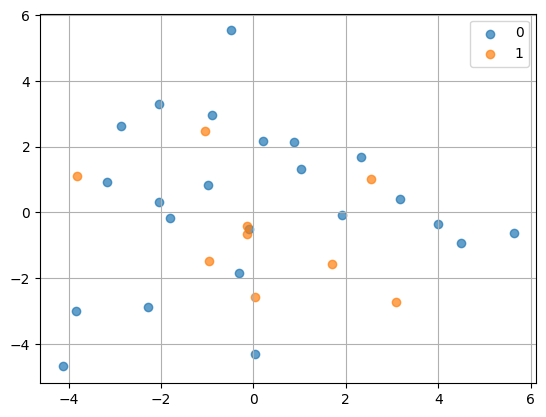

In [15]:
assert labels[:, 0].unsqueeze(1).shape == (labels.shape[0], 1), "You have to preprocess labels before using pca_latent display function"
pca_latent(labels=labels[:, 0].unsqueeze(1), mu_logvars=(mus, logvars))

In [16]:
print(encoder.flattened_size, encoder.out_encoder_shape)

262144 torch.Size([256, 32, 32])


### Decoder

In [17]:
#Sample latent
z = sample_from((mus, logvars))
print(f"Latent space is a {z.shape}")
decoder = Decoder(out_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, out_encoder_shape=encoder.out_encoder_shape)
x_hat_logits = decoder(z)
try: assert x_hat_logits.shape == (x_hat_logits.shape[0], in_channels, img_size, img_size)
except AssertionError as e : 
    print(x_hat_logits.shape)
    print("!!!!WARNING : reconstruction error : output of the decoder must be with the a same shape as the input")

Latent space is a torch.Size([32, 64])


In [23]:
x_hat_logits.shape

torch.Size([32, 3, 256, 256])

tensor(-0.9874, grad_fn=<MinBackward1>) tensor(0.9978, grad_fn=<MaxBackward1>)


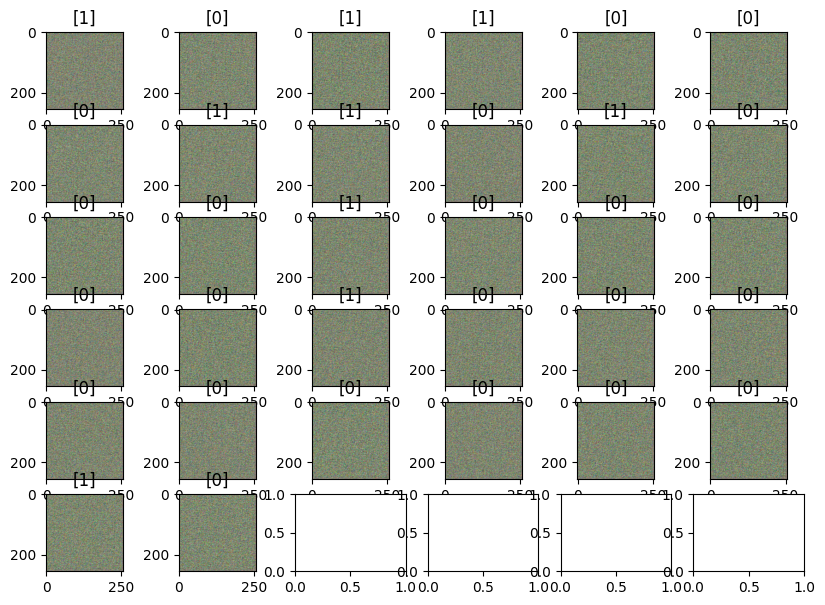

In [19]:
assert x_hat_logits.shape==image.shape, "shape error"
print(x_hat_logits.min(), x_hat_logits.max())
display((x_hat_logits, labels[:, 0].unsqueeze(1)))
loss_mse = mse(x_hat_logits, image)
loss_kl = kl(*(mus, logvars))

### VAE - train

In [4]:
batch = next(iter(loader))
images, labels = batch
images.shape
images.min()

tensor(0.)

Prior to any train :

Sanity check : torch.Size([32, 3, 256, 256])


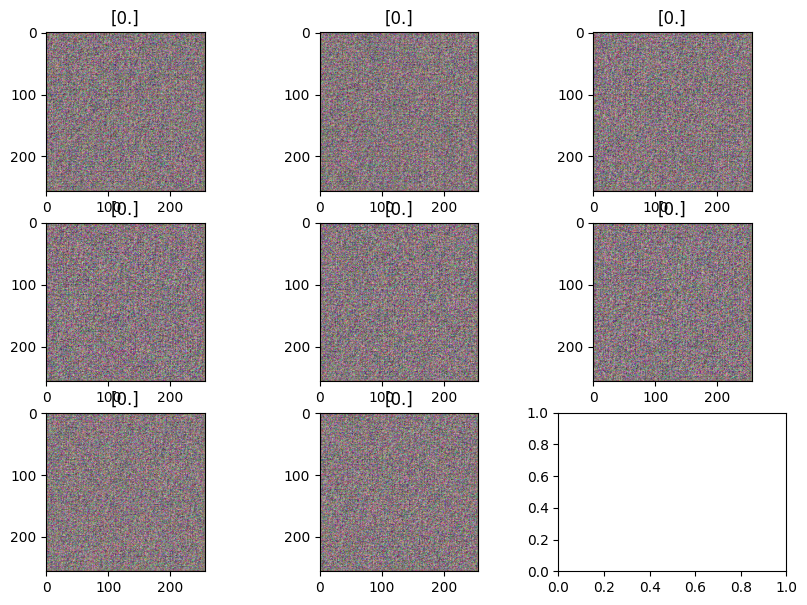

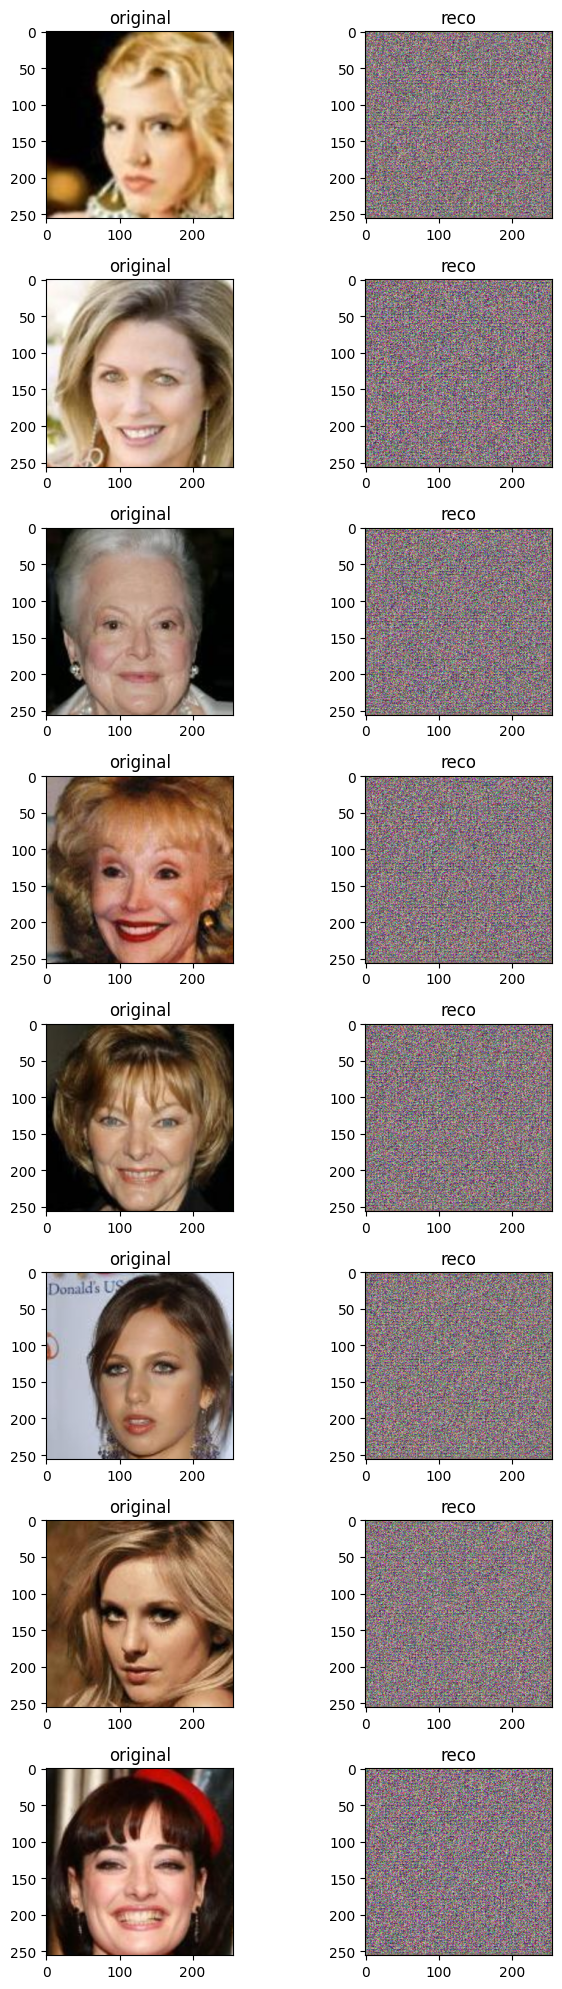

In [5]:
beta=0
vae = VAEModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, beta=beta, warm_up=False)
image_hat_logits = vae(images)
print(f"Sanity check : {image_hat_logits[0].shape}")
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

In [6]:
max_epoch=2
trainer = Trainer(
        accelerator="auto",
        devices=[3],
        max_epochs=max_epoch,
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(vae, loader)

/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2025-05-19 18:48:18.163924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 18:48:18.172957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747673298.184278  200088 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747673298.187201  200088 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempti

Epoch 0:   0%|          | 17/5087 [00:40<3:22:02,  0.42it/s, v_num=2]Train loss: nan


ValueError: NaN loss

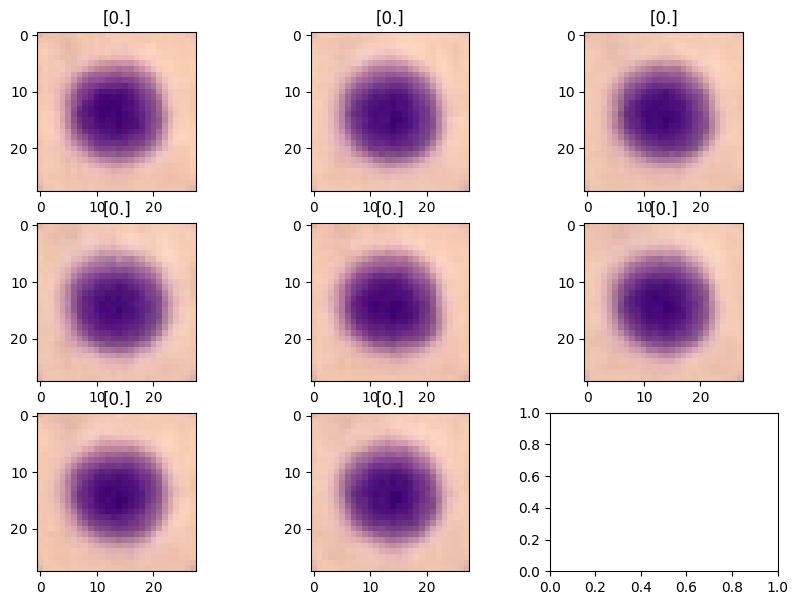

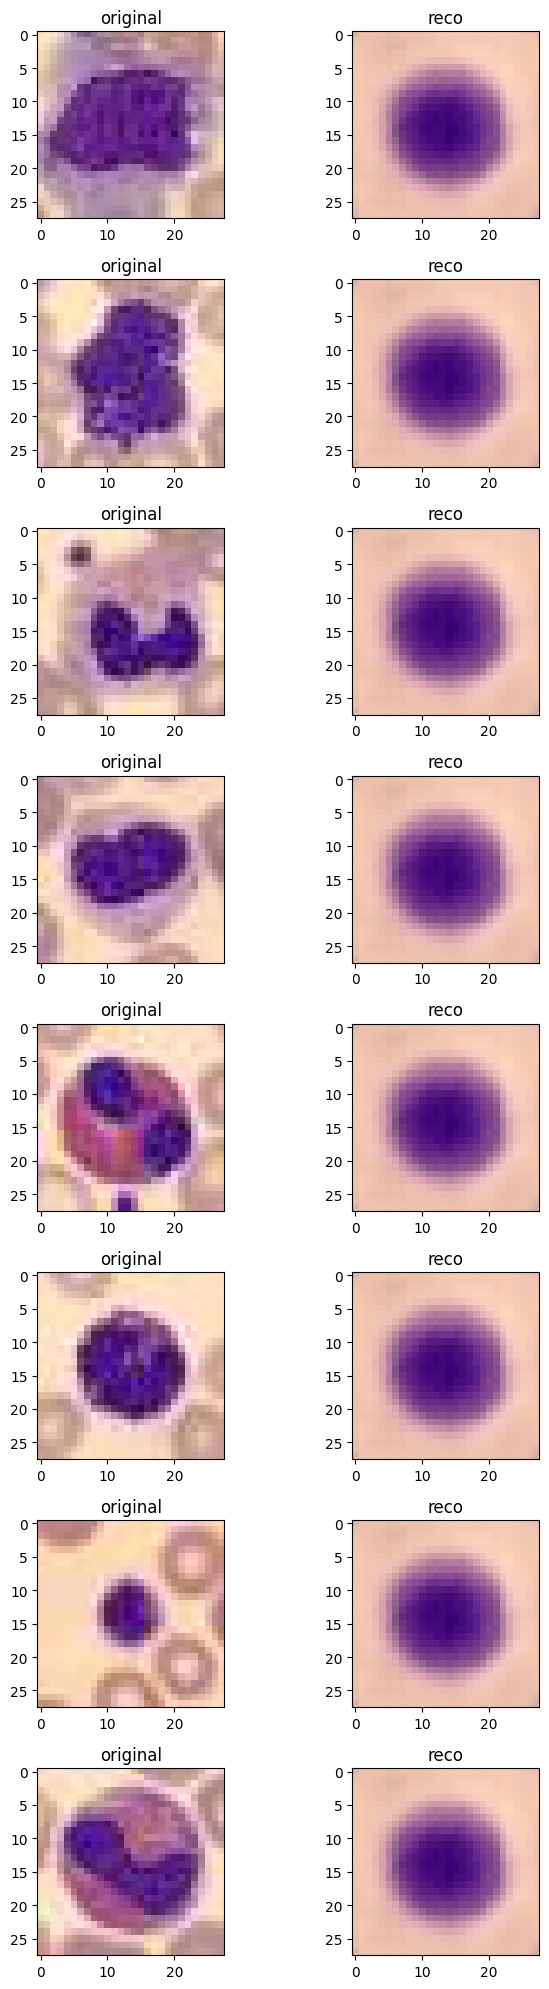

In [15]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

Then with beta at 10 :

In [12]:
beta=4
vae = VAEModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, beta=beta)
image_hat_logits = vae(images)
print(f"Sanity check : {image_hat_logits[0].shape}")

max_epoch=10000
version=f"vae_epoch={max_epoch}_beta={beta}_latent={LATENT_DIM}"
trainer = Trainer(
        accelerator="auto",
        devices=[0, 2, 3],
        strategy="ddp_notebook",
        max_epochs=max_epoch,
        logger=TensorBoardLogger(
            save_dir=LOG_DIR+"/vae",
            name=BloodMNIST.Path.VAE,
            version=version,
            default_hp_metric=False,
        ),
        callbacks=[
            ModelCheckpoint(monitor="loss/val", mode="min"),
            LearningRateMonitor("epoch"),
        ]
    )
trainer.fit(vae, toy_loader)

#vae.reconstruct()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity check : torch.Size([32, 3, 28, 28])


/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting wi

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Train loss: 7.599297046661377
Train loss: 7.776298522949219
Train loss: 7.576843738555908
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, v_num=t=64]

/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='loss/val')` could not find the monitored key in the returned metrics: ['lr-AdamW', 'loss/kl', 'loss/reco', 'loss/beta', 'loss/train', 'epoch', 'step']. HINT: Did you call `log('loss/val', value)` in the `LightningModule`?


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=t=64]        Train loss: 7.3294148445129395Train loss: 7.150649070739746
Train loss: 7.099356651306152

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=t=64]        Train loss: 6.8235764503479
Train loss: 6.70339822769165
Train loss: 6.714141368865967
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=t=64]        Train loss: 6.3223090171813965
Train loss: 6.24782133102417
Train loss: 6.48986291885376
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=t=64]        Train loss: 5.777370452880859Train loss: 6.143771648406982

Train loss: 6.030650615692139
Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=t=64]        Train loss: 5.609210014343262Train loss: 5.653980255126953

Train loss: 5.624977111816406
Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=t=64]        Train loss: 5.259526252746582Train loss: 5.5830206871032715

Train loss: 5.183332443237305
Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=t=64]        

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 43.79it/s, v_num=t=64]


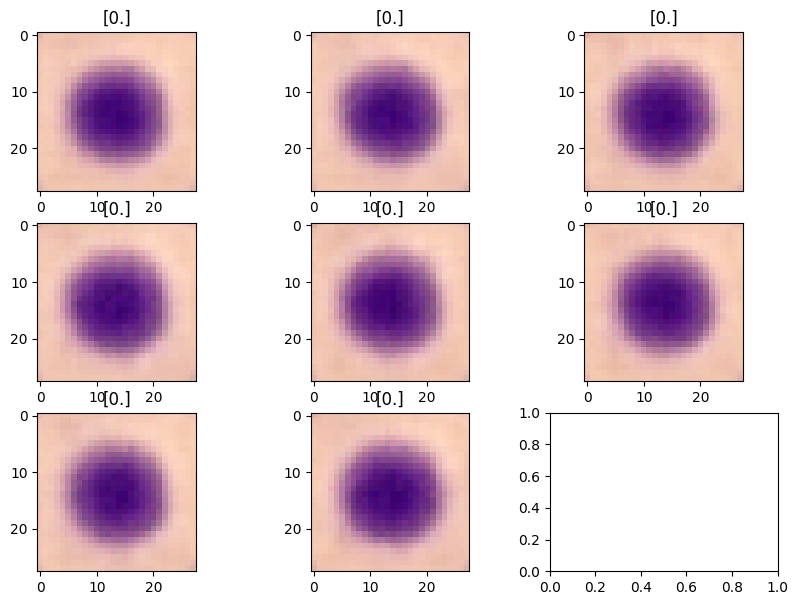

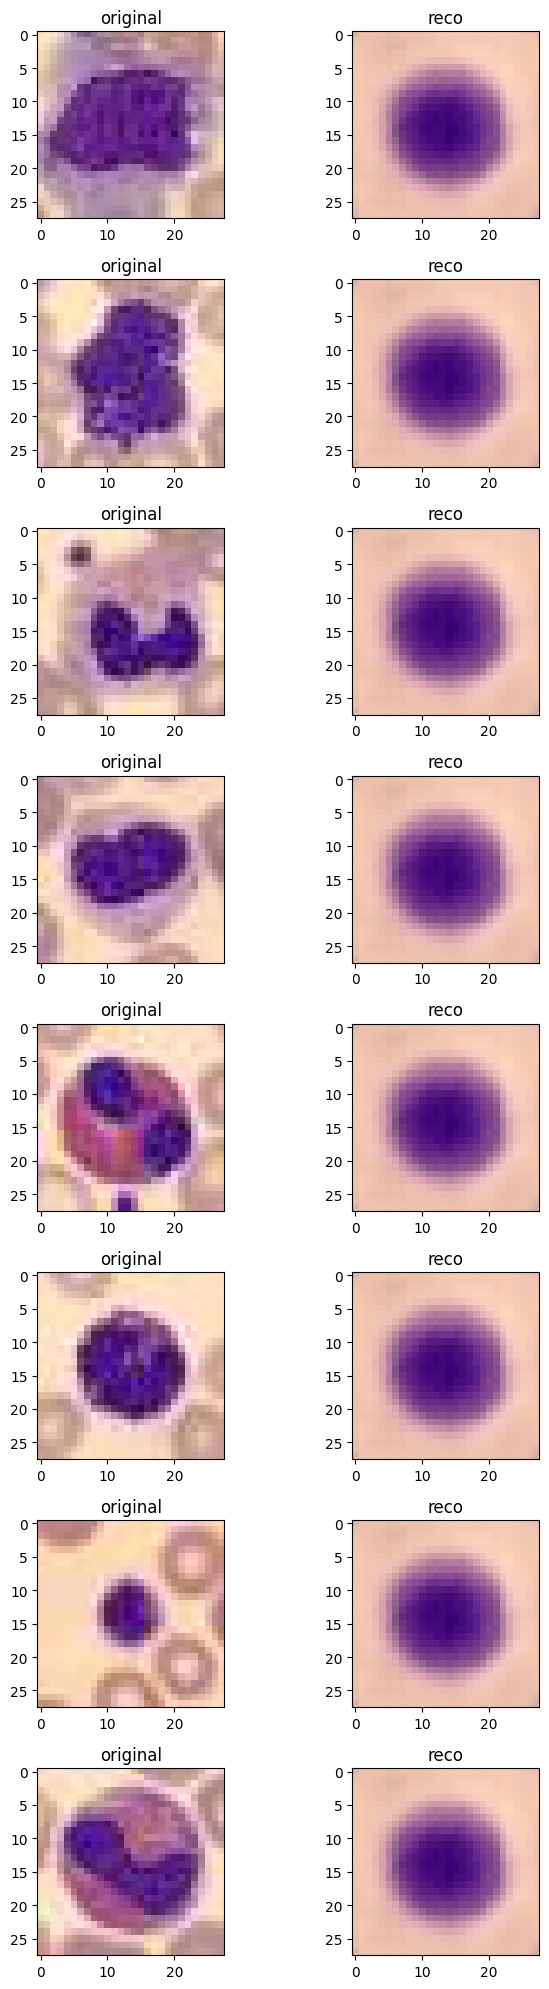

In [14]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

#### [DEBUG VAE]

##### Test - loss

In [ ]:
#kl test
mu = torch.tensor([[0,0,0,0]])
logvar = torch.tensor([[0, 0, 0, 0]])
kl_loss = kl(mu, logvar)
assert abs(kl_loss - 0.0) < 10e-3, "Error in kl implementation"
print(f"kl ok. kl={kl_loss}")

#mse test
k=2
images_hat_logits = torch.zeros([1, 3, 28, 28])
images = k*torch.ones([1, 3, 28, 28])
mse_loss = mse(images_hat_logits, images)
assert abs(mse_loss-k**2) < 10e-3
print(f"mse ok. mse={mse_loss}")

kl ok. kl=0.0
mse ok. mse=4.0


In [ ]:
test = torch.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/bloodmnist/bloodmnist_test.pt")

In [ ]:
test[0].shape

torch.Size([3421, 3, 28, 28])

##### Auto Encoder (VAE without sampling and only reco loss)

In [ ]:
ae = AEModule.load_from_checkpoint("disdiff_adapters/logs/ae/shapes/ae_epoch=10_beta=1.0_latent=128/checkpoints/epoch=9-step=384000.ckpt")

In [1]:
ae.show_reconstruct(images)

NameError: name 'ae' is not defined

## Multi-Distillme

From "load data" images.shape=torch.Size([8, 3, 28, 28])
28 is not a power of 2. Interpolation from this shape to (torch.Size([192, 4, 4]), torch.Size([192, 4, 4]))


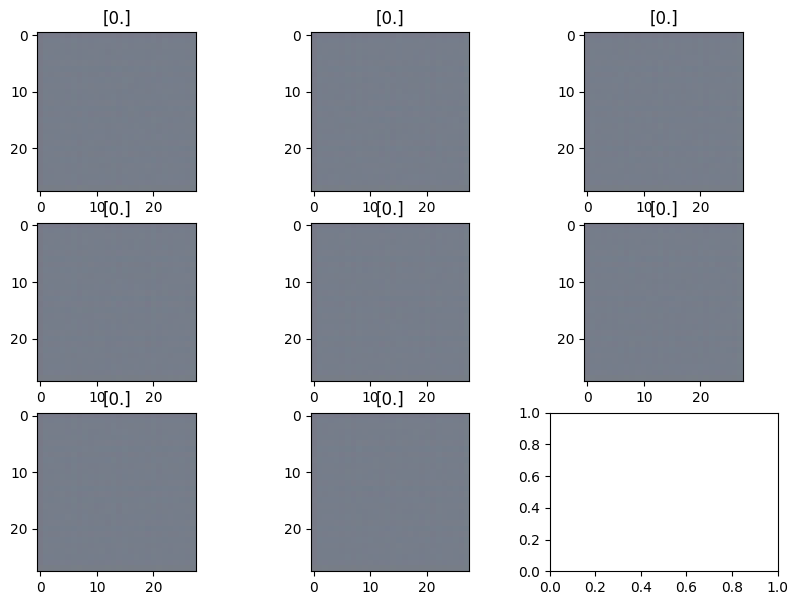

In [ ]:
multi_dm = MultiDistillMeModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)
print(f"From \"load data\" images.shape={images.shape}")

images_gen = multi_dm.generate()
labels_gen = torch.zeros([images_gen.shape[0],1])
display((images_gen, labels_gen))

In [ ]:
import torch
from lightning import LightningModule

from disdiff_adapters.arch.vae import *
from disdiff_adapters.utils import sample_from, pca_latent, display
from disdiff_adapters.loss import *


class _MultiDistillMe(torch.nn.Module) : 
    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int) :
        
        super().__init__()

        self.encoder_s = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim)
        
        self.encoder_t = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim)
        
        self.merge_operation = torch.add
        
        self.decoder = Decoder(out_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim,
                               out_encoder_shape=self.encoder_s.out_encoder_shape)
        
        self.labels_buff = []
        self.latent_buff = []
        
    def forward(self, images: torch.Tensor) :

        #forward t
        mus_logvars_s = self.encoder_s(images)
        z_s = sample_from(mus_logvars_s)

        #forward_t
        mus_logvars_t = self.encoder_t(images)
        z_t = sample_from(mus_logvars_t)

        #merge latent vector from s and t
        z = self.merge_operation(z_s, z_t)

        #decoder
        image_hat_logits = self.decoder(z)

        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
class MultiDistillMeDataModule(LightningModule) :

    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int,
                 beta_s: float=1.0,
                 beta_t: float=1.0) :
        
        super().__init__()
        self.save_hyperparameters()

        self.model = _MultiDistillMe(in_channels=self.hparams.in_channels,
                                     img_size=self.hparams.img_size,
                                     latent_dim=self.hparams.latent_dim,)
            
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters())
    
    def generate(self, nb_samples: int=8) :
        eps_s = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim]))
        eps_t = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim]))
        z = self.model.merge_operation(eps_s, eps_t)

        x_hat_logits = self.model.decoder(z)
        return x_hat_logits
    
    def forward(self, images: torch.Tensor) :
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.model(images)
        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
    def loss(self, mus_logvars_s, mus_logvars_t, image_hat_logits, images, log_components=False) :

        weighted_kl_s = self.hparams.beta_s*kl(mus_logvars_s)
        weighted_kl_t = self.hparams.beta_t*kl(mus_logvars_t)
        reco = mse(image_hat_logits, images)

        if log_components :
            self.log("loss/kl_s", weighted_kl_s)
            self.log("loss/kl_t", weighted_kl_t)
            self.log("loss/reco", reco)

        return weighted_kl_t+weighted_kl_s+reco
    
    def training_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits, log_components=True)

        print(f"Train loss: {loss}")
        
        if torch.isnan(loss):
            raise ValueError("NaN loss")

        self.log("loss/train", loss)
        return loss

    def validation_step(self, batch: tuple[torch.Tensor]):
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits)

        self.log("loss/val", loss)
        print(f"Val loss: {loss}")
    
    def test_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)

        weighted_kl_s = self.hparams.beta_s*kl(mus_logvars_s)
        weighted_kl_t = self.hparams.beta_t*kl(mus_logvars_t)
        reco = mse(image_hat_logits, images)

        self.log("loss/reco_test", reco)
        self.log("loss/kl_s_test", weighted_kl_s)
        self.log("loss/kl_t_test", weighted_kl_t)
        self.log("loss/test", reco+weighted_kl_t+weighted_kl_s)

    def on_test_end(self):
        images_gen = self.generate()
        labels_gen = torch.zeros([images_gen.shape[0],1])
        display((images_gen, labels_gen))
        self.logger = TensorBoardLogger
        self.logger.log_image()


28 is not a power of 2. Interpolation from this shape to (torch.Size([192, 4, 4]), torch.Size([192, 4, 4]))


AttributeError: can't set attribute 'logger'

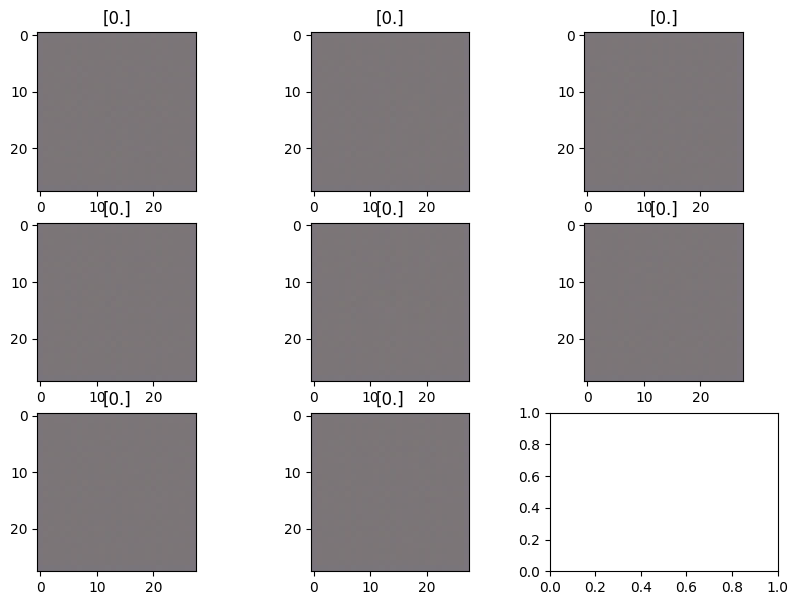

In [15]:
multi_dm = MultiDistillMeDataModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)
multi_dm.on_test_end()